Epoch 1/100


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 193.6710 - val_loss: 200.1258
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 188.7124 - val_loss: 189.2031
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 177.0982 - val_loss: 170.8244
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 157.7190 - val_loss: 140.7538
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 122.4822 - val_loss: 97.8416
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 75.3058 - val_loss: 51.8409
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.1047 - val_loss: 23.6577
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.5412 - val_loss: 14.0559
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.0584 - val_loss: 10.7512
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.0168 - val_loss: 8.8428
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2862 - val_loss: 7.2846
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms


Model saved successfully.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Custom Accuracy (within 10% of actual value): 97.86%


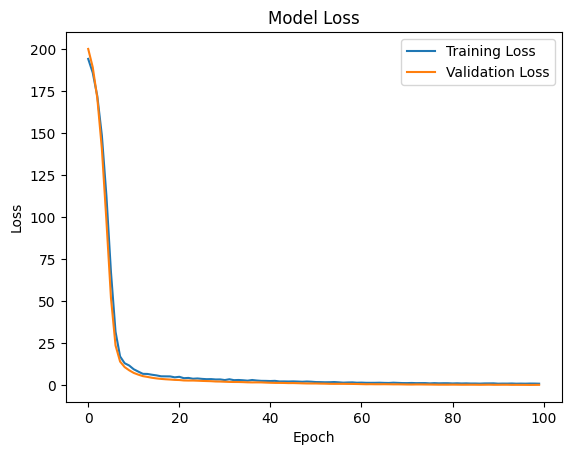

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('river_data.csv')

# Drop rows with missing values
df = df.dropna()

# Drop 'Date' column and separate features and target variable
X = df.drop(['Predicted_Water_Level', 'Date'], axis=1)
y = df['Predicted_Water_Level']

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for LSTM (sequence length of 1)
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Optional: Add dropout for regularization
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {test_loss:.4f}')

# Save the trained model
model.save('water_level_prediction_model.h5')
print("Model saved successfully.")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate custom accuracy (e.g., percentage of predictions within 10% of the actual value)
threshold = 0.1  # 10% threshold
accuracy = np.mean(np.abs((y_pred.flatten() - y_test) / y_test) < threshold)
print(f'Custom Accuracy (within 10% of actual value): {accuracy * 100:.2f}%')

# Optional: Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [3]:
# Load the saved model
loaded_model = load_model('water_level_prediction_model.h5')
print("Model loaded successfully.")

# Function to make predictions
def predict_water_level(input_data, scaler, model):
    # Ensure input_data is a DataFrame
    if isinstance(input_data, dict):
        input_data = pd.DataFrame([input_data])
    
    # Normalize the input data
    input_scaled = scaler.transform(input_data)
    
    # Reshape for LSTM (sequence length of 1)
    input_scaled = input_scaled.reshape(input_scaled.shape[0], 1, input_scaled.shape[1])
    
    # Make prediction
    prediction = model.predict(input_scaled)
    return prediction[0][0]  # Return the predicted value

# Example input (replace with your own data)
example_input = {
    'Historical_Water_Level': 8.54,
    'Rainfall': 0.15,
    'Temperature': 14.69,
    'Seasonality_Month': 1,
    'Upstream_Flow': 133.24,
    'Evaporation': 1.84,
    'Soil_Moisture': 11.81,
    'Wind_Speed': 1.91,
    'Humidity': 76.08,
    'Pressure': 1010.49
}

# Make a prediction
predicted_water_level = predict_water_level(example_input, scaler, loaded_model)
print(f"Predicted Water Level: {predicted_water_level:.4f}")

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted Water Level: 16.2955
